## Figure 5: Comparing GLM vs. GLM-HMM Model Performance

This notebook recreates the figure panels included in Figure 5 of [Bolkan, Stone et al 2021](https://www.biorxiv.org/content/10.1101/2021.07.23.453573v1). It also serves as a useful tutorial notebook for users who are looking to compare GLM vs. GLM-HMM performance for models fit to their own experimental data.

The general premise of this notebook/figure, in the context of the paper, is that we fit a Bernoulli GLM to our data and realized that a GLM does not provide a great explanation of the data. Instead, we considered a model (called a GLM-HMM) in which the animals' decision-making process could be described by multiple GLMs, each one corresponding to a different internal state or task strategy. After testing how many states best describes the data (see <code>extdatafig7.ipynb</code> for details) we settled on a 3-state GLM-HMM. Below, we'll compare how the 3-state GLM-HMM performs relative to the standard GLM. 

We will conclude at the end of this notebook that the 3-state GLM-HMM performs better than the GLM, and so we'll stick with that model for all subsequent paper analyses. 

------------------
### Running Cross-Validation
For a few of the figure panels, we're going to train the models on training data and then compare model performance when fit to test data. This requires us to first run cross-validation for both models.
####  Import the required code packages and modules.

In [160]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from glmhmm import glm, glm_hmm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load the data

In [161]:
# load the data for the indirect pathway cohort
x_d2 = np.load('data/indirect_x.npy') # z-scored design matrix
y_d2 = np.load('data/indirect_y.npy') # vector of right and left choices for each trial
sessions_d2 = np.load('data/indirect_sessions.npy') # vector of session start and stop indices
mouseIDs_d2 = np.load('data/indirect_mouseIDs.npy') # vector of mouse IDs for each trial
trialTypes_d2 = np.load('data/indirect_trialTypes.npy') # vector of trial types (which side rewarded) for each trial

# load the data for the direct pathway cohort
x_d1 = np.load('data/direct_x.npy') # z-scored design matrix
y_d1 = np.load('data/direct_y.npy') # vector of right and left choices for each trial
sessions_d1 = np.load('data/direct_sessions.npy') # vector of session start and stop indices
mouseIDs_d1 = np.load('data/direct_mouseIDs.npy') # vector of mouse IDs for each trial
trialTypes_d1 = np.load('data/direct_trialTypes.npy') # vector of trial types (which side rewarded) for each trial

#### Split the data

Now, let's split our data into train and test sets. This can be a little tricky to do with real data, as we don't necessarily want to split the data randomly. Instead, we'll want to preserve session structure (as opposed to splitting trials within sessions). Because of individual differences in animals, we'll also want to try to balance the test sets so that they contain approximately the same number of sessions per mouse. 

In [162]:
from glmhmm.utils import splitData

## indirect pathway cohort --------------------------------------------------------

# initialize as lists since not every test/train set will be exactly the same size
x_train_d2, x_test_d2, y_train_d2, y_test_d2, sessions_train_d2, sessions_test_d2, testIx_d2 = [],[],[],[],[],[],[]

# specify seeds for splitting the data for reproducibility
seeds = [55,38,13,23,103]

# split the data
for seed in seeds:
    trainIx, sessionsTrain, testIx, sessionsTest = splitData(sessions_d2,mouseIDs_d2,testSize=0.2,seed=seed)
    x_train_d2.append(x_d2[trainIx,:])
    x_test_d2.append(x_d2[testIx,:])
    y_train_d2.append(y_d2[trainIx])
    y_test_d2.append(y_d2[testIx])
    sessions_train_d2.append(sessionsTrain)
    sessions_test_d2.append(sessionsTest)
    testIx_d2.append(testIx)
    
## direct pathway cohort --------------------------------------------------------
    
# initialize as lists since not every test/train set will be exactly the same size
x_train_d1, x_test_d1, y_train_d1, y_test_d1, sessions_train_d1, sessions_test_d1, testIx_d1 = [],[],[],[],[],[],[]

# specify seeds for splitting the data for reproducibility
seeds = [10,66,100,73,200]

# split the data
for seed in seeds:
    trainIx, sessionsTrain, testIx, sessionsTest = splitData(sessions_d1,mouseIDs_d1,testSize=0.2,seed=seed)
    x_train_d1.append(x_d1[trainIx,:])
    x_test_d1.append(x_d1[testIx,:])
    y_train_d1.append(y_d1[trainIx])
    y_test_d1.append(y_d1[testIx])
    sessions_train_d1.append(sessionsTrain)
    sessions_test_d1.append(sessionsTest)
    testIx_d1.append(testIx)

#### Fit GLMs to the training sets

In [163]:
M = 10 # number of input features
C = 2 # number of observation classes
folds = 5

## indirect pathway cohort --------------------------------------------------------
fit_glms_d2 = np.zeros((folds),dtype=object)
for i in range(folds):
    N = x_train_d2[i].shape[0] 
    fit_glms_d2[i] = glm.GLM(N,M,C,observations="bernoulli")
    w_init = fit_glms_d2[i].init_weights()
    results = fit_glms_d2[i].fit(x_train_d2[i],w_init,y_train_d2[i],compHess=False)
    
## direct pathway cohort --------------------------------------------------------
fit_glms_d1 = np.zeros((folds),dtype=object)
for i in range(folds):
    N = x_train_d1[i].shape[0] 
    fit_glms_d1[i] = glm.GLM(N,M,C,observations="bernoulli")
    w_init = fit_glms_d1[i].init_weights()
    results = fit_glms_d1[i].fit(x_train_d1[i],w_init,y_train_d1[i],compHess=False)

#### Fit GLM-HMMs to the training sets
The cell below will take about 20 hours to run (~2 hours per fold x 5 folds x 2 datasets) but of course you can speed this up by putting the code below into a python script and running it for each fold (and initialization) in parallel.  

In [167]:
from glmhmm.utils import find_best_fit

K = 3
inits = 20 # set the number of initializations

## indirect pathway cohort --------------------------------------------------------
best_fit_GLMHMMs_d2 = np.zeros((folds),dtype=object)
for j in range(folds):
    # store values for each initialization
    lls_all = np.zeros((inits,250))
    real_GLMHMMs = np.zeros((inits),dtype=object)

    # fit the model for each initialization
    N = x_train_d2[j].shape[0]
    for i in range(inits): 
        real_GLMHMMs[i] = glm_hmm.GLMHMM(N,M,C,K,observations="bernoulli")
        A_init,w_init,_ = real_GLMHMMs[i].generate_params(weights=['GLM',-0.2,1.2,x_train_d2[j],y_train_d2[j],1])                   
        lls_all[i],_,_,_ = real_GLMHMMs[i].fit(y_train_d2[j],x_train_d2[j],A_init,w_init,sess=sessions_train_d2[j]) 
    # store results from best fit
    bestix = find_best_fit(lls_all)
    best_fit_GLMHMMs_d2[j] = real_GLMHMMs[bestix]
    
## direct pathway cohort --------------------------------------------------------
best_fit_GLMHMMs_d1 = np.zeros((folds),dtype=object)
for j in range(folds):
    # store values for each initialization
    lls_all = np.zeros((inits,250))
    real_GLMHMMs = np.zeros((inits),dtype=object)

    # fit the model for each initialization
    N = x_train_d1[j].shape[0]
    for i in range(inits): 
        real_GLMHMMs[i] = glm_hmm.GLMHMM(N,M,C,K,observations="bernoulli")
        A_init,w_init,_ = real_GLMHMMs[i].generate_params(weights=['GLM',-0.2,1.2,x_train_d1[j],y_train_d1[j],1])                   
        lls_all[i],_,_,_ = real_GLMHMMs[i].fit(y_train_d1[j],x_train_d1[j],A_init,w_init,sess=sessions_train_d1[j]) 
    # store results from best fit
    bestix = find_best_fit(lls_all)
    best_fit_GLMHMMs_d1[j] = real_GLMHMMs[bestix]

### Figure 5c: GLM vs. GLM-HMM Cross-Validated Log-Likelihood
Now we'll compute the test loglikelihoods for the fit GLM and GLM-HMM models for each mouse and plot the results to see how much improvement in performance we see for the GLM-HMM over the GLM.

In [168]:
from glmhmm.analysis import compare_LL_GLMvsGLMHMM

## indirect pathway cohort --------------------------------------------------------
unique_mouseIDs = np.unique(mouseIDs_d2)
numMice = len(unique_mouseIDs)
test_lls_d2 = np.zeros((folds,numMice,2))
for j in range(folds):
    test_mouseIDs = mouseIDs_d2[testIx_d2[j]]
    for i in range(numMice):
        test_mouse_ix = np.where(test_mouseIDs == unique_mouseIDs[i])[0]
        test_lls_d2[j,i] = compare_LL_GLMvsGLMHMM(fit_glms_d2[j],best_fit_GLMHMMs_d2[j],x_test_d2[j][test_mouse_ix,:],
                                               y_test_d2[j][test_mouse_ix])
avg_test_lls_d2 = np.mean(test_lls_d2,axis=0)
        
## direct pathway cohort --------------------------------------------------------
unique_mouseIDs = np.unique(mouseIDs_d1)
numMice = len(unique_mouseIDs)
test_lls_d1 = np.zeros((folds,numMice,2))
for j in range(folds):
    test_mouseIDs = mouseIDs_d1[testIx_d1[j]]
    for i in range(numMice):
        test_mouse_ix = np.where(test_mouseIDs == unique_mouseIDs[i])[0]
        test_lls_d1[j,i] = compare_LL_GLMvsGLMHMM(fit_glms_d1[j],best_fit_GLMHMMs_d1[j],x_test_d1[j][test_mouse_ix,:],
                                               y_test_d1[j][test_mouse_ix])
avg_test_lls_d1 = np.mean(test_lls_d1,axis=0)

Text(0, 0.5, 'GLM-HMM log-likelihood \n (bits/session)')

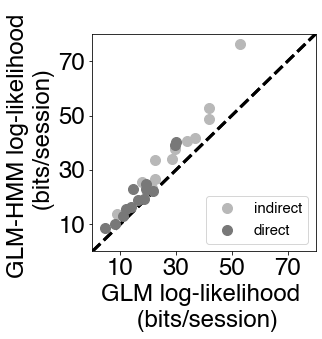

In [349]:
from glmhmm.visualize import plot_glmvsglmhmm_performance
    
fig, ax = plt.subplots(1)
fig.set_size_inches(4, 4)

labels = ['indirect','direct']
colors = np.array([[184,184,184],[120,120,120]])/255
avg_sess_lengths = [np.mean(np.diff(sessions_d2)),np.mean(np.diff(sessions_d1))]

plot_glmvsglmhmm_performance(avg_test_lls_d2,labels[0],colors[0],avg_sess_lengths[0],ax)
plot_glmvsglmhmm_performance(avg_test_lls_d1,labels[1],colors[1],avg_sess_lengths[1],ax)

ax.set_xlabel('GLM log-likelihood \n (bits/session)', fontsize=24)
ax.set_ylabel('GLM-HMM log-likelihood \n (bits/session)',fontsize=24)

### Figure 5d: GLM vs GLM-HMM Prediction Accuracy
Now we'll compare the predictive accuracy on the test sets for both models, looking at all trials as well as only the trials when the laser is on. 

In [199]:
from glmhmm.analysis import compare_predictions_GLMvsGLMHMM

## indirect pathway cohort --------------------------------------------------------
unique_mouseIDs = np.unique(mouseIDs_d2)
numMice = len(unique_mouseIDs)
test_pred_d2 = np.zeros((folds,numMice,2))
for j in range(folds):
    test_mouseIDs = mouseIDs_d2[testIx_d2[j]]
    for i in range(numMice):
        test_mouse_ix = np.where(test_mouseIDs == unique_mouseIDs[i])[0]
        test_pred_d2[j,i] = compare_predictions_GLMvsGLMHMM(fit_glms_d2[j],best_fit_GLMHMMs_d2[j],
                                                           x_test_d2[j][test_mouse_ix,:],y_test_d2[j][test_mouse_ix])
avg_test_pred_d2 = np.mean(test_pred_d2,axis=0)

test_pred_d2 = np.zeros((folds,numMice,2))
for j in range(folds):
    test_mouseIDs = mouseIDs_d2[testIx_d2[j]]
    for i in range(numMice):
        test_mouse_ix = np.where(test_mouseIDs == unique_mouseIDs[i])[0]
        test_pred_d2[j,i] = compare_predictions_GLMvsGLMHMM(fit_glms_d2[j],best_fit_GLMHMMs_d2[j],
                                                           x_test_d2[j][test_mouse_ix,:],y_test_d2[j][test_mouse_ix],
                                                           laser_only=True)
avg_test_pred_d2_laser = np.mean(test_pred_d2,axis=0)
        
## direct pathway cohort --------------------------------------------------------
unique_mouseIDs = np.unique(mouseIDs_d1)
numMice = len(unique_mouseIDs)
test_pred_d1 = np.zeros((folds,numMice,2))
#alphas = []
for j in range(folds):
    test_mouseIDs = mouseIDs_d1[testIx_d1[j]]
    alpha = []
    for i in range(numMice):
        test_mouse_ix = np.where(test_mouseIDs == unique_mouseIDs[i])[0]
        test_pred_d1[j,i] = compare_predictions_GLMvsGLMHMM(fit_glms_d1[j],best_fit_GLMHMMs_d1[j],
                                                           x_test_d1[j][test_mouse_ix,:],y_test_d1[j][test_mouse_ix])
        
#         alpha.append(al)
#     alphas.append(alpha)
avg_test_pred_d1 = np.mean(test_pred_d1,axis=0)


test_pred_d1 = np.zeros((folds,numMice,2))
for j in range(folds):
    test_mouseIDs = mouseIDs_d1[testIx_d1[j]]
    for i in range(numMice):
        test_mouse_ix = np.where(test_mouseIDs == unique_mouseIDs[i])[0]
        test_pred_d1[j,i] = compare_predictions_GLMvsGLMHMM(fit_glms_d1[j],best_fit_GLMHMMs_d1[j],
                                                           x_test_d1[j][test_mouse_ix,:],y_test_d1[j][test_mouse_ix],
                                                           laser_only=True)
avg_test_pred_d1_laser = np.mean(test_pred_d1,axis=0)

Text(0.5, 1.0, 'laser trials')

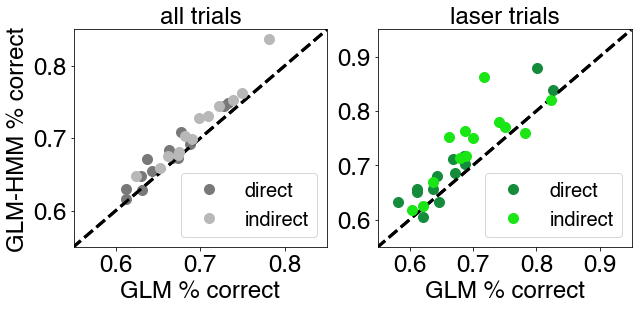

In [212]:
from glmhmm.visualize import plot_glmvsglmhmm_performance

fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 4)
avg_sess_lengths = [1,1] # don't scale by session lengths in this case
labels = ['indirect','direct']

## all trials
colors = np.array([[184,184,184],[120,120,120]])/255
plot_glmvsglmhmm_performance(avg_test_pred_d1,labels[1],colors[1],avg_sess_lengths[1],ax[0],axis_len=0.95)
plot_glmvsglmhmm_performance(avg_test_pred_d2,labels[0],colors[0],avg_sess_lengths[0],ax[0],axis_len=0.95)

# set custom axis settings
ax[0].set_xlim([0.55,0.85])
ax[0].set_ylim([0.55,0.85])
ax_range = np.round(np.arange(0.6,0.85,0.1),2)
ax[0].set_xticks(ax_range)
ax[0].set_yticks(ax_range)
ax[0].set_xticklabels(ax_range)
ax[0].set_yticklabels(ax_range)
ax[0].set_xlabel('GLM % correct')
ax[0].set_ylabel('GLM-HMM % correct')
ax[0].set_title('all trials',fontsize=24)

## laser only trials 
colors = np.array([[25,230,20],[20,140,60]])/255
plot_glmvsglmhmm_performance(avg_test_pred_d1_laser,labels[1],colors[1],avg_sess_lengths[1],ax[1],axis_len=0.95)
plot_glmvsglmhmm_performance(avg_test_pred_d2_laser,labels[0],colors[0],avg_sess_lengths[0],ax[1],axis_len=0.95)

# set custom axis settings
ax[1].set_xlim([0.55,0.95])
ax[1].set_ylim([0.55,0.95])
ax_range = np.round(np.arange(0.6,0.95,0.1),2)
ax[1].set_xticks(ax_range)
ax[1].set_yticks(ax_range)
ax[1].set_xticklabels(ax_range)
ax[1].set_yticklabels(ax_range)
ax[1].set_xlabel('GLM % correct')
ax[1].set_title('laser trials',fontsize=24)

### Figure 5e/f: Histograms of Consecutive Choices Contra/Ipsilateral to Inhibited Hemisphere
Lastly, we can compute run lengths -- or consecutive trials in which the animal's choice was consistent with the bias direction produced by the laser -- for both the real data and GLM and GLM-HMM simulations. This will allow us to see which model better captures the temporal structure in the effect of DMS laser inhibition on choice as seen in the real data.

For this analysis, we'll need to load the model objects from fitting the GLM and 3-state GLM-HMM to all the data (see <code>fig4.ipynb</code> and <code>fig6.ipynb</code>)

In [3]:
import pickle
# load fit GLMs
GLM_d2 = pickle.load(open('fit models/GLM_d2.pickle','rb'))
GLM_d1 = pickle.load(open('fit models/GLM_d1.pickle','rb'))
# load fit GLM-HMMS
GLMHMM_d2 = pickle.load(open('fit models/GLMHMM_d2.pickle','rb'))
GLMHMM_d1 = pickle.load(open('fit models/GLMHMM_d1.pickle','rb'))

In [87]:
from glmhmm.analysis import blocks_of_laser_effect, fit_line_to_hist

num_bins = 40
num_sims = 100

## indirect pathway cohort --------------------------------------------------------
#real data 
bin_edges_d2, bin_heights_d2 = blocks_of_laser_effect(sessions_d2,y_d2,x_d2[:,2],num_bins=num_bins,side_bias=-1)

# glm simulations 
bin_heights_glm_d2 = np.zeros((num_sims,num_bins))
np.random.seed(1)
for i in range(num_sims):
    # simulate data
    _, sim_y_d2 = GLM_d2.generate_data_from_fit(GLM_d2.w,x_d2,obs_ix=[3,9,10],replace=True,\
                                                         sessions=sessions_d2,outcomes=trialTypes_d2)
    # get histogram of run lengths
    _, bin_heights_glm_d2[i,:] = blocks_of_laser_effect(sessions_d2,sim_y_d2,x_d2[:,2],
                                                        num_bins=num_bins,bin_edges=bin_edges_d2,side_bias=-1)

# # glm-hmm simulations
bin_heights_glmhmm_d2 = np.zeros((num_sims,num_bins))
for i in range(num_sims):
    # simulate data
    _, sim_y_d2, _ = GLMHMM_d2.generate_data_from_fit(GLMHMM_d2.w,GLMHMM_d2.A,x_d2,obs_ix=[3,9,10],replace=True,
                                                     sessions=sessions_d2,outcomes=trialTypes_d2)
    # get histogram of run lengths
    _, bin_heights_glmhmm_d2[i,:] = blocks_of_laser_effect(sessions_d2,sim_y_d2,x_d2[:,2],
                                                           num_bins=num_bins,bin_edges=bin_edges_d2,side_bias=-1)

## direct pathway cohort --------------------------------------------------------
# real data 
bin_edges_d1, bin_heights_d1 = blocks_of_laser_effect(sessions_d1,y_d1,x_d1[:,2],num_bins=num_bins,side_bias=1)

# glm simulations 
bin_heights_glm_d1 = np.zeros((num_sims,num_bins))
for i in range(num_sims):
    # simulate data
    _, sim_y_d1 = GLM_d1.generate_data_from_fit(GLM_d1.w,x_d1,obs_ix=[3,9,10],replace=True,\
                                                sessions=sessions_d1,outcomes=trialTypes_d1)
    # get histogram of run lengths
    _, bin_heights_glm_d1[i,:] = blocks_of_laser_effect(sessions_d1,sim_y_d1,x_d1[:,2],
                                                        num_bins=num_bins,bin_edges=bin_edges_d1,side_bias=1)

# # glm-hmm simulations
bin_heights_glmhmm_d1 = np.zeros((num_sims,num_bins))
for i in range(num_sims):
    # simulate data
    _, sim_y_d1, _ = GLMHMM_d1.generate_data_from_fit(GLMHMM_d1.w,GLMHMM_d1.A,x_d1,obs_ix=[3,9,10],replace=True,
                                                     sessions=sessions_d2,outcomes=trialTypes_d2)
    # get histogram of run lengths
    _, bin_heights_glmhmm_d1[i,:] = blocks_of_laser_effect(sessions_d1,sim_y_d1,x_d1[:,2],
                                                           num_bins=num_bins,bin_edges=bin_edges_d1,side_bias=1)

Text(0.5, 1.0, 'direct pathway')

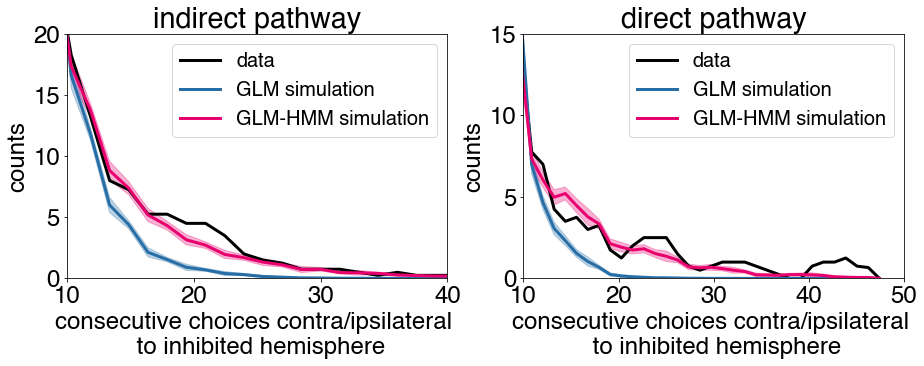

In [141]:
from glmhmm.visualize import plot_histogram_run_lengths

fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 4.5)

colors = [np.array([0,0,0])/255,np.array([39,110,167])/255,np.array([233,0,111])/255]

## indirect pathway cohort --------------------------------------------------------
plot_histogram_run_lengths(bin_heights_d2,bin_edges_d2,axes[0],color=colors[0],label='data')
plot_histogram_run_lengths(bin_heights_glm_d2,bin_edges_d2,axes[0],color=colors[1],label='GLM simulation')
plot_histogram_run_lengths(bin_heights_glmhmm_d2,bin_edges_d2,axes[0],color=colors[2],label='GLM-HMM simulation')
axes[0].set_xlim([10,40])
axes[0].set_xticks(np.arange(10,50,10))
axes[0].set_ylim([0,20])
axes[0].set_title('indirect pathway',fontweight='bold')

# ## direct pathway cohort --------------------------------------------------------
plot_histogram_run_lengths(bin_heights_d1,bin_edges_d1,axes[1],color=colors[0],label='data')
plot_histogram_run_lengths(bin_heights_glm_d1,bin_edges_d1,axes[1],color=colors[1],label='GLM simulation')
plot_histogram_run_lengths(bin_heights_glmhmm_d1,bin_edges_d1,axes[1],color=colors[2],label='GLM-HMM simulation')
axes[1].set_xlim([10,50])
axes[1].set_xticks(np.arange(10,60,10))
axes[1].set_ylim([0,15])
axes[1].set_title('direct pathway',fontweight='bold')